Let's try a regressor.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.neural_network import MLPRegressor

In [2]:
df = pd.read_csv('https://github.com/datasciencedojo/datasets/raw/master/titanic.csv')
df['is_female'] = df.apply(lambda row: int(row['Sex']=='female'),axis = 1)
features = ['Pclass','Age', 'SibSp','Parch','Survived','is_female']
target = ['Fare']
df = df.dropna(subset = features+target)
x_tr,x_va,y_tr,y_va = train_test_split(df[features],df['Fare'],test_size = 0.3,random_state = 0)
scaler = StandardScaler() # neural networks are sensitive to scaling
scaler.fit(x_tr)
x_tr_sc = scaler.transform(x_tr)
x_va_sc = scaler.transform(x_va)

In [8]:
nnr = MLPRegressor(max_iter=2000) # must set max_iter; it won't converge with the default max_iter
nnr.fit(x_tr,y_tr)
nnr.score(x_va,y_va)

0.6277323747002768

As always, we may supply our model with inputs to get predictions. Compare the prediction to actual for the third row.

In [9]:
x_va.head(3)

Pclass    Age  SibSp  Parch  Survived  is_female
423       3  28.00      1      1         0          1
177       1  50.00      0      0         0          1
305       1   0.92      1      2         1          0

In [11]:
inp = np.array((1,.92,1,2,1,0)).reshape(1,6)
nnr.predict(inp)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


array([121.0626994])

In [12]:
y_va.head(3)

423     14.4000
177     28.7125
305    151.5500
Name: Fare, dtype: float64

Recall: the weights are stored in .coefs_ and the biases in .intercepts_. We can use this, along with knowledge that relu($x$)=max($0,x$), to reconstruct a particular prediction.

In [18]:
nnr.coefs_[1].shape

(100, 1)

In [21]:
nnr.coefs_[0].shape

(6, 100)

In [19]:
# define the relu function
def relu(array):
    array = array[0] # we are given an array consisting of an array
    return(np.array([max(0,x) for x in array]).reshape(1,100))

In [35]:
# multiply the input (1,6) by the first set of weights (6,100)
pred = np.matmul(inp,nnr.coefs_[0])

In [40]:
# add the first bias vector
pred += nnr.intercepts_[0]

In [38]:
# apply the relu function
pred = relu(pred)

In [34]:
# finally, multiply by the next set of weights and add the final bias vector
np.matmul(pred,nnr.coefs_[1])+nnr.intercepts_[1]

array([[121.0626994]])

Let's apply a MLP to the mnist dataset.

In [56]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from PIL import Image
from io import BytesIO as sio
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
# load the figures
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

In [44]:
# display a figure
f = sio()
Image.fromarray(np.uint8(255-x_tr[0])).save(f, 'png')
ipd.display(ipd.Image(data=f.getvalue()))

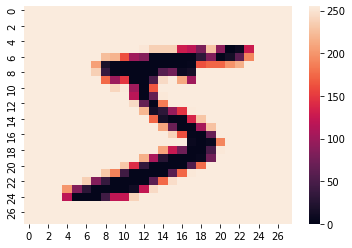

In [45]:
# we can also just use a heatmap
sns.heatmap(255-x_tr[0]);

In [48]:
x_tr.shape

(60000, 28, 28)

In [49]:
# the inputs are given in 2d arrays, and we need them to be 1d arrays
x_tr_2d = [x.reshape(-1,) for x in x_tr]
x_te_2d = [x.reshape(-1,) for x in x_te]

In [50]:
# fit a MLP - it will take a couple minutes
nn = MLPClassifier()
nn.fit(x_tr_2d,y_tr)

MLPClassifier()

In [51]:
nn.score(x_te_2d,y_te)

0.9668

Let's visualize activation patterns for the first hidden layer. To do this, we give 784 inputs to the network and measure the value of a node in the hidden layer each time. The first input we give is 255 followed by all 0s, which shows the activation level for the first bit. Then 0, 255, and the rest 0s, and so on.

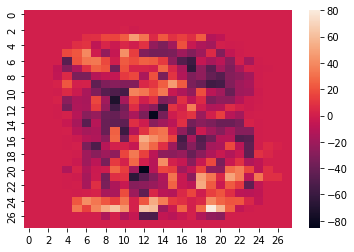

In [54]:
k = 2 # which hidden layer node to visualize
res = []
for i in range(784):
    inp = np.zeros(784)
    inp[i]=255
    res.append(np.matmul(inp,nn.coefs_[0][:,k]))
sns.heatmap(pd.DataFrame(np.array(res).reshape(28,28)));

We can plot a bunch at once.

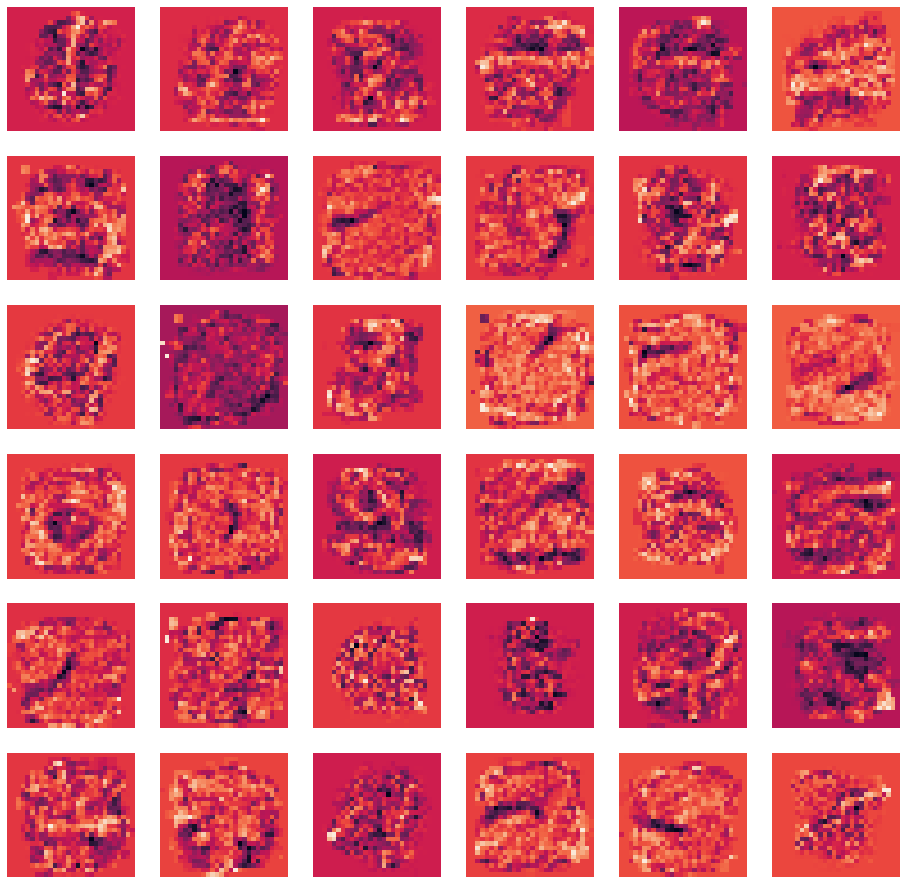

In [57]:
fig,axes = plt.subplots(6,6,figsize = (16,16))
for idx in range(36):
    res = []
    for i in range(784):
        inp = np.zeros(784)
        inp[i]=255
        res.append(np.matmul(inp,nn.coefs_[0][:,idx]))
    sns.heatmap(pd.DataFrame(np.array(res).reshape(28,28)),ax=axes[idx//6,idx%6],cbar = False)
plt.setp(axes, xticks=[], yticks=[]);

How to control the number of layers and the number of neurons per layer. We'll do two hidden layers with 16 neurons each.

In [58]:
nn2 = MLPClassifier(hidden_layer_sizes = (16,16))
nn2.fit(x_tr_2d,y_tr)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(16, 16))

In [59]:
nn2.score(x_te_2d,y_te)

0.9384

We can review the test samples which were mislabelled by the model.

q to quit
index: 38
predicted: 3


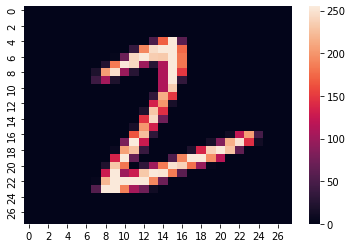

q to quit
index: 61
predicted: 2


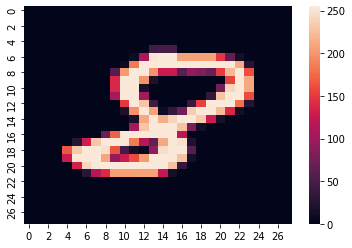

q to quit
index: 92
predicted: 4


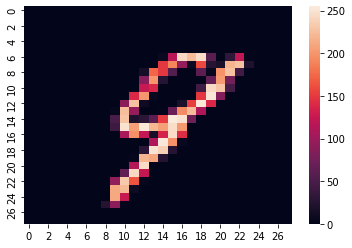

q to quit
index: 115
predicted: 9


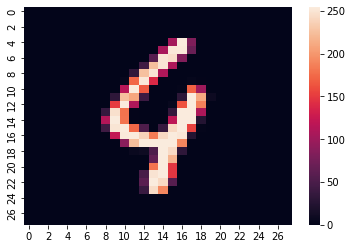

q to quit
index: 119
predicted: 3


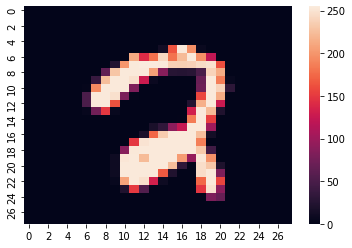

q to quit
index: 125
predicted: 4


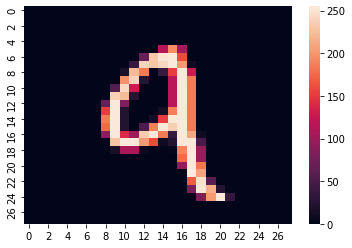

q to quit
index: 149
predicted: 5


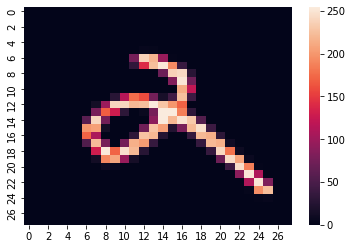

q to quit
index: 151
predicted: 8


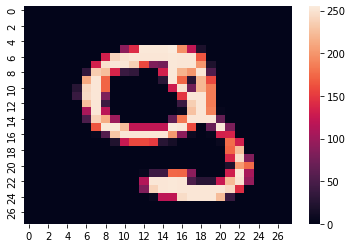

KeyboardInterrupt: Interrupted by user

In [62]:
preds = nn2.predict(x_te_2d)
wrongs = iter(np.where(y_te != preds)[0])
inpt = ''
while inpt != 'q':
    idx = next(wrongs)
    inpt = input('q to quit')
    print(f'index: {idx}\npredicted: {nn2.predict([x_te_2d[idx]])[0]}')
    sns.heatmap(x_te[idx])
    plt.show();

Let's plot the activation patterns of the first hidden layer.

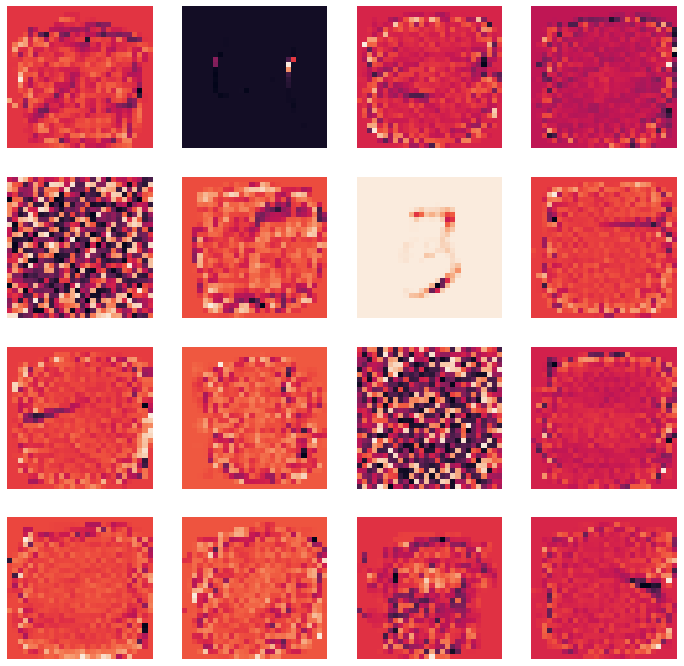

In [63]:
fig,axes = plt.subplots(4,4,figsize = (12,12))
for idx in range(16):
    res = []
    for i in range(784):
        inp = np.zeros(784)
        inp[i]=255
        res.append(np.matmul(inp,nn2.coefs_[0][:,idx]))
    sns.heatmap(pd.DataFrame(np.array(res).reshape(28,28)),ax=axes[idx//4,idx%4],cbar = False)
plt.setp(axes, xticks=[], yticks=[]);

Compare that to, say, a decision tree.

In [64]:
from sklearn.tree import DecisionTreeClassifier
tr = DecisionTreeClassifier()
tr.fit(x_tr_2d,y_tr)
tr.score(x_te_2d,y_te)

0.8755

In [65]:
xs = range(1,47,5)
acc_tr = []
acc_te = []
for i in xs:
    tr = DecisionTreeClassifier(max_depth = i)
    tr.fit(x_tr_2d,y_tr)
    acc_tr.append(tr.score(x_tr_2d,y_tr))
    acc_te.append(tr.score(x_te_2d,y_te))

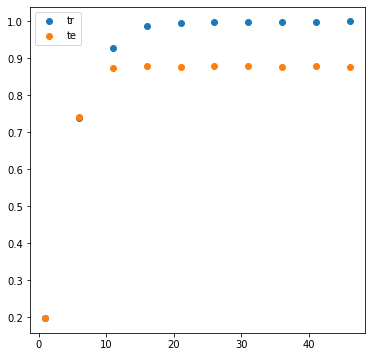

In [66]:
fig,ax = plt.subplots(figsize = (6,6))
ax.scatter(xs,acc_tr,label = 'tr')
ax.scatter(xs,acc_te,label = 'te')
ax.legend();